In [ ]:
# import time

# start_time = time.time()

# # Code cần đo thời gian
# result = sum(range(1000000))

# end_time = time.time()

# print(f"Thời gian thực thi: {end_time - start_time} giây")

In [1]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.1 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import skfuzzy as fuzz

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
# from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import ImageChops
from skimage.morphology import binary_dilation, disk

In [4]:
import os
import random

In [5]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [6]:
torch.cuda.empty_cache()

In [7]:
num_classes = 3

In [8]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=3)

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [9]:
train_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/train'
val_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/val'
test_dir = '/kaggle/input/collect-leaf-potato-data/dtpotatov3/test'
save_path = '/kaggle/working/mobilenetv3100.pt'
save_best = '/kaggle/working/mobilenetv3100_best.pt'

In [10]:
# Thiết lập tăng cường dữ liệu
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_vt = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_vt)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_vt)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [13]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
     

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [15]:
def train(model, train_loader, val_loader, save_path, save_best, criterion, optimizer, num_epochs=5, patience=3):
    train_accs = []
    train_losss = []
    val_accs = []
    val_losss = []
    epochs_no_improve = 0
    best_loss= 5.0
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        correct = 0
        total = 0
        
        
        for inputs, labels in train_loader:
            # Đưa dữ liệu lên GPU nếu có
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Reset gradient
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass và tối ưu
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_accuracy = correct / total * 100  # Tính toán accuracy

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f}% , Training Loss: {train_loss:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total * 100

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}% , Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            # Lưu mô hình nếu có cải thiện
            torch.save(model.state_dict(), save_best)
            print(f"Validation loss improved. Model saved to {save_best}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

        # Kiểm tra nếu không có cải thiện qua nhiều epochs thì dừng
        if epochs_no_improve >= patience:
            torch.save(model.state_dict(), save_path)
            print(f"Early stopping at epoch {epoch+1} and save Last.")
            break
        
        train_accs.append(train_accuracy)
        train_losss.append(train_loss)
        val_accs.append(val_accuracy)
        val_losss.append(val_loss)
        
        model.train()
    return train_accs, train_losss, val_accs, val_losss, epoch

In [16]:
import time

In [17]:
start_time = time.time()
accs, losss, val_accs, val_losss, num_epochs=train(model, train_loader, val_loader, save_path, save_best, criterion, optimizer, 30)
end_time = time.time()

Epoch [1/30], Training Accuracy: 84.73% , Training Loss: 0.5581
Epoch [1/30], Validation Accuracy: 90.18% , Validation Loss: 0.2859
Validation loss improved. Model saved to /kaggle/working/mobilenetv3100_best.pt
Epoch [2/30], Training Accuracy: 95.22% , Training Loss: 0.1860
Epoch [2/30], Validation Accuracy: 94.45% , Validation Loss: 0.1951
Validation loss improved. Model saved to /kaggle/working/mobilenetv3100_best.pt
Epoch [3/30], Training Accuracy: 96.62% , Training Loss: 0.1153
Epoch [3/30], Validation Accuracy: 95.09% , Validation Loss: 0.1456
Validation loss improved. Model saved to /kaggle/working/mobilenetv3100_best.pt
Epoch [4/30], Training Accuracy: 97.45% , Training Loss: 0.1008
Epoch [4/30], Validation Accuracy: 95.55% , Validation Loss: 0.1580
No improvement in validation loss for 1 epoch(s).
Epoch [5/30], Training Accuracy: 97.29% , Training Loss: 0.0901
Epoch [5/30], Validation Accuracy: 96.18% , Validation Loss: 0.1519
No improvement in validation loss for 2 epoch(s).


In [ ]:
# 372,497s

In [18]:
print(f"Thời gian thực thi: {end_time - start_time} giây")

Thời gian thực thi: 372.49398159980774 giây


In [19]:
def visualize_results(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(15, 8))
    
    # 1. Learning Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

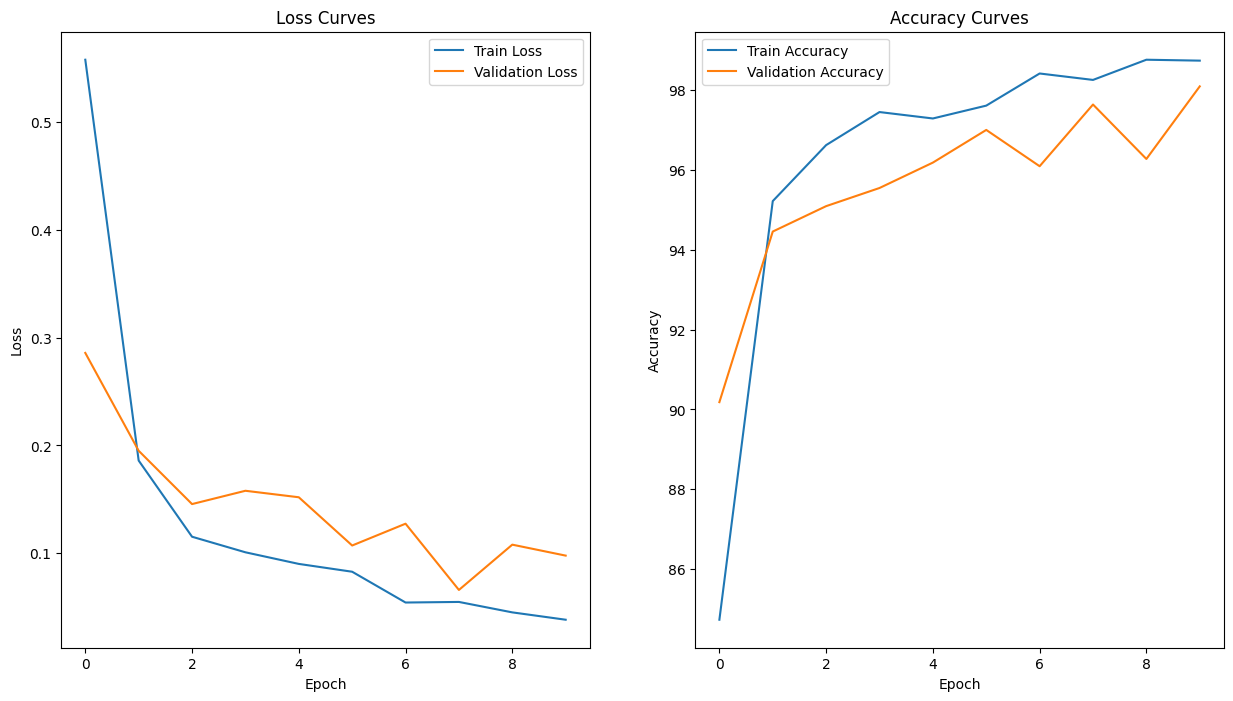

In [20]:
visualize_results(losss, accs, val_losss, val_accs)

In [23]:
model1 = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=3)
state_dict = torch.load('/kaggle/working/mobilenetv3100_best.pt')
model1.load_state_dict(state_dict)

model1 = model1.to(device)
model1.eval();

/tmp/ipykernel_30/2289919518.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/working/mobilenetv3100_best.pt')


Confusion Matrix:
 [[356   3   9]
 [  0 130   3]
 [  3   3 340]]


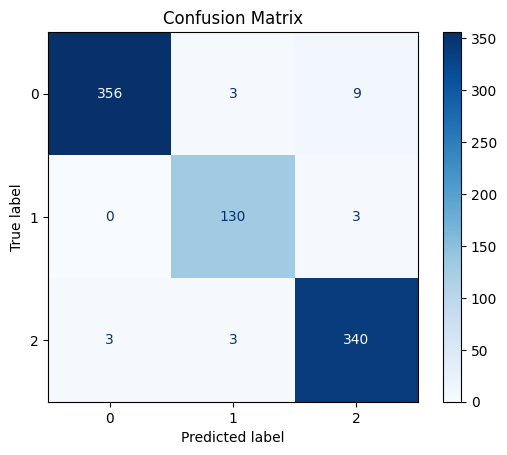

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       368
           1       0.96      0.98      0.97       133
           2       0.97      0.98      0.97       346

    accuracy                           0.98       847
   macro avg       0.97      0.98      0.97       847
weighted avg       0.98      0.98      0.98       847



In [24]:
model.eval()

# Danh sách chứa các nhãn dự đoán và nhãn thực
all_preds = []
all_labels = []

with torch.no_grad():  # Tắt tính toán gradient
    for images, labels in test_loader:  # Giả sử bạn có một DataLoader cho tập kiểm tra
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Lấy nhãn dự đoán
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Chuyển đổi thành mảng NumPy
y_true = np.array(all_labels)
y_pred_classes = np.array(all_preds)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Vẽ ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Tính toán các độ đo
print(classification_report(y_true, y_pred_classes))

Confusion Matrix:
 [[357   3   8]
 [  1 130   2]
 [  1   6 339]]


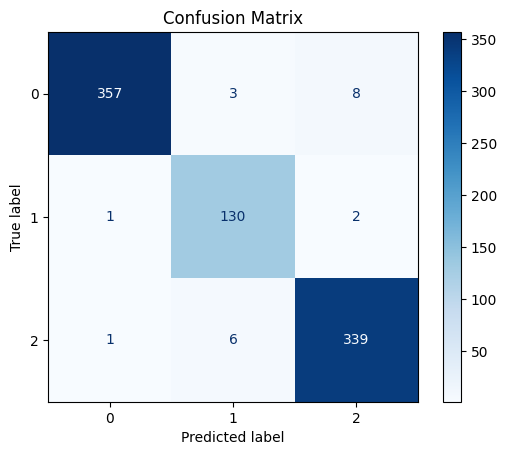

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       368
           1       0.94      0.98      0.96       133
           2       0.97      0.98      0.98       346

    accuracy                           0.98       847
   macro avg       0.97      0.98      0.97       847
weighted avg       0.98      0.98      0.98       847



In [25]:
model1.eval()

# Danh sách chứa các nhãn dự đoán và nhãn thực
all_preds = []
all_labels = []

with torch.no_grad():  # Tắt tính toán gradient
    for images, labels in test_loader:  # Giả sử bạn có một DataLoader cho tập kiểm tra
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        _, preds = torch.max(outputs, 1)  # Lấy nhãn dự đoán
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Chuyển đổi thành mảng NumPy
y_true = np.array(all_labels)
y_pred_classes = np.array(all_preds)

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Vẽ ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Tính toán các độ đo
print(classification_report(y_true, y_pred_classes))

In [26]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.hooks = []
        self._register_hook()
        

    def _register_hook(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.hooks.append(self.target_layer.register_forward_hook(forward_hook))
        self.hooks.append(self.target_layer.register_backward_hook(backward_hook))
    
    

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()
        self.model.zero_grad()

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1

        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients.detach().cpu().numpy()[0]
        # 
        activations = self.activations.detach().cpu().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
#         weights = np.mean(gradients, axis=(0, 1))
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations, axis=0)

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

In [27]:
def display_gradcam(img, imgo, grad_cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img
    superimposed_img = superimposed_img / np.max(superimposed_img)

    plt.figure(figsize=(15, 8))
    
    plt.subplot(131)
    plt.imshow(imgo)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(superimposed_img)
    plt.colorbar( ticks=[0, 0.5, 1]).set_ticklabels(['Không ảnh hưởng', 'Tương đối', 'Quan trọng'])
    plt.axis('off')
    plt.show()

In [28]:
def get_detailed_explanation(pred_label):
    explanations = {
        0: {
            "symptoms": "Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn"
        },
        1: {
            "symptoms": "Healthy: Không có vết bệnh hay đóm bệnh nào."
        },
        2: {
            "symptoms": "Late blight: Có màu từ nhạt đến xanh đậm, vết nhỏ thường có dạng tròn và khi lan ra không có dạng cố định và cũng chuyển sang nâu đen rồi đen tím."
        }
    }
    return explanations.get(pred_label, {})

In [29]:
model.eval()
model1.eval()

class_names = ['early_blight', 'healthy', 'late_blight'] 

In [30]:
def change_opacity_to_color(image, color=(255, 255, 0)):
    # Tách kênh alpha
    r, g, b = image.split()
    # Thay đổi tất cả pixel có alpha > 0 thành màu mới
    result = Image.merge("RGB", (
        r.point(lambda i: color[0] if i == 0 else i),
        g.point(lambda i: color[1] if i == 0 else i),
        b.point(lambda i: color[2] if i == 0 else i),
    ))
    return result

In [31]:
class LimeHybridViTExplainer:
    def __init__(self, model, preprocess_fn, device='cuda'):
        self.model = model
        self.preprocess_fn = preprocess_fn
        self.device = device
        self.explainer = lime_image.LimeImageExplainer()

    def get_pil_transform(self):
        def transform_img(img):
            return img.convert('RGB')
        return transform_img

    def get_preprocess_transform(self):
        def preprocess(img):
            return self.preprocess_fn(img).unsqueeze(0)
        return preprocess
    
    def batch_predict(self, images):
        self.model.eval()
        batch = torch.stack([self.preprocess_fn(img) for img in images])
        batch = batch.to(self.device)
        logits = self.model(batch)
        probs = nn.functional.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    def explain(self, image, num_samples=1500, num_feature=4, target_label=None, top_labels=3, hide_color=0, positive_only=True):
        transform_fn = self.get_pil_transform()
        image_transformed = transform_fn(image)

        explanation = self.explainer.explain_instance(
            np.array(image_transformed),
            self.batch_predict,
            top_labels=top_labels,
            hide_color=hide_color,
            num_samples=num_samples
        )

        if target_label is None:
            target_label = explanation.top_labels[0]

        temp, mask = explanation.get_image_and_mask(
            target_label, positive_only=positive_only, num_features=num_feature, hide_rest=True
        )
        
        width, height = mask.shape[:2]
        thickness = 35 
        mask_thicker = binary_dilation(mask, footprint=disk(thickness))
        
        white = np.ones((height, width, 3), dtype=np.uint8)
        outlined_image = mark_boundaries(white, mask_thicker, color=(0, 0, 0), mode='outer')
        outlined_image = (outlined_image * 255).astype(np.uint8)
        outlined_image = Image.fromarray(outlined_image)
        
        outlined_image = change_opacity_to_color(outlined_image, color=(255, 0, 0))
        overlay_image = ImageChops.multiply(image.convert('RGBA'), outlined_image.convert('RGBA').point(lambda i: i > 0 and 255))
        result_image = Image.alpha_composite(image.convert('RGBA'), overlay_image)

        return temp, result_image, explanation

    def visualize(self, image, img, mask):
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
        ax1.imshow(np.array(img))
        ax1.axis('off')
        ax1.set_title('Original Image')

        ax2.imshow(np.array(image))
        ax2.axis('off')
        ax2.set_title('Segment')

        ax3.imshow(np.array(mask))
        ax3.axis('off')
        ax3.set_title('LIME ')

        plt.tight_layout()
        plt.show()

# Define the preprocessing functions
def get_pil_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
    ])

def get_preprocess_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [32]:
def fz_fn_segment_fc(url, rdn, n_clusters=5, hsv=True, w_center=0.1, err=0.005, m=2):
    w_center=w_center/2
    img = Image.open(url)
    image_array = np.array(img)
    if hsv:
        image_hsv = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
    else:
        image_hsv=image_array
        
    Z = image_hsv.reshape((-1, 3))
    Z = Z / 255.0

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            Z.T, n_clusters, m, error=err, maxiter=1000, init=None, seed=rdn)
        
    cluster_membership = np.argmax(u, axis=0)
    segmented_image = cluster_membership.reshape(image_array.shape[:2])
        
  # loạt 1
    mask = np.where(segmented_image == 1, cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
   
 # Áp dụng GrabCut với mask 1
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(image_hsv, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)
    
 # Tách nền 1
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    width, height = mask2.shape[:2]    
    center_pixel_r = mask2[(width // 2)-int(width* w_center):(width // 2)+int(width* w_center), (height // 2)-int(height* w_center):(height // 2)+int(height* w_center)]
    center=False
    outline=0
            
    segmented_imaged=np.zeros(mask2.shape[:2], dtype=np.uint8)
    center_pixel=np.any(center_pixel_r == 0)    
    if(center_pixel):
       center=True
    if(center):
       segmented_imaged[mask2 == 0] = 1
    else:
       segmented_imaged = mask2

  # loạt 2
    mask3 = np.where(segmented_imaged == 1, cv2.GC_PR_FGD, cv2.GC_PR_BGD).astype('uint8')
  # Áp dụng GrabCut với mask 2
    bgd_model1 = np.zeros((1, 65), np.float64)
    fgd_model1 = np.zeros((1, 65), np.float64)
    cv2.grabCut(image_hsv, mask3, None, bgd_model1, fgd_model1, 5, cv2.GC_INIT_WITH_MASK)
    
  # Tách nền 2
    mask4 = np.where((mask3 == 2) | (mask3 == 0) , 0, 1).astype('uint8') 
    
    # segmented_image = image_array * mask2[:, :, np.newaxis]
    segmented_image1 = image_array * mask4[:, :, np.newaxis]

    segmented_image1 = Image.fromarray(segmented_image1)
   
    return segmented_image1, img, mask4

In [33]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
explainer = LimeHybridViTExplainer(model, preprocess_transform, device='cuda')
explainer1 = LimeHybridViTExplainer(model1, preprocess_transform, device='cuda')




In [34]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [38]:
target_layer = model.blocks[5][2].conv_pw 
target_layer1 = model1.blocks[5][2].conv_pw

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


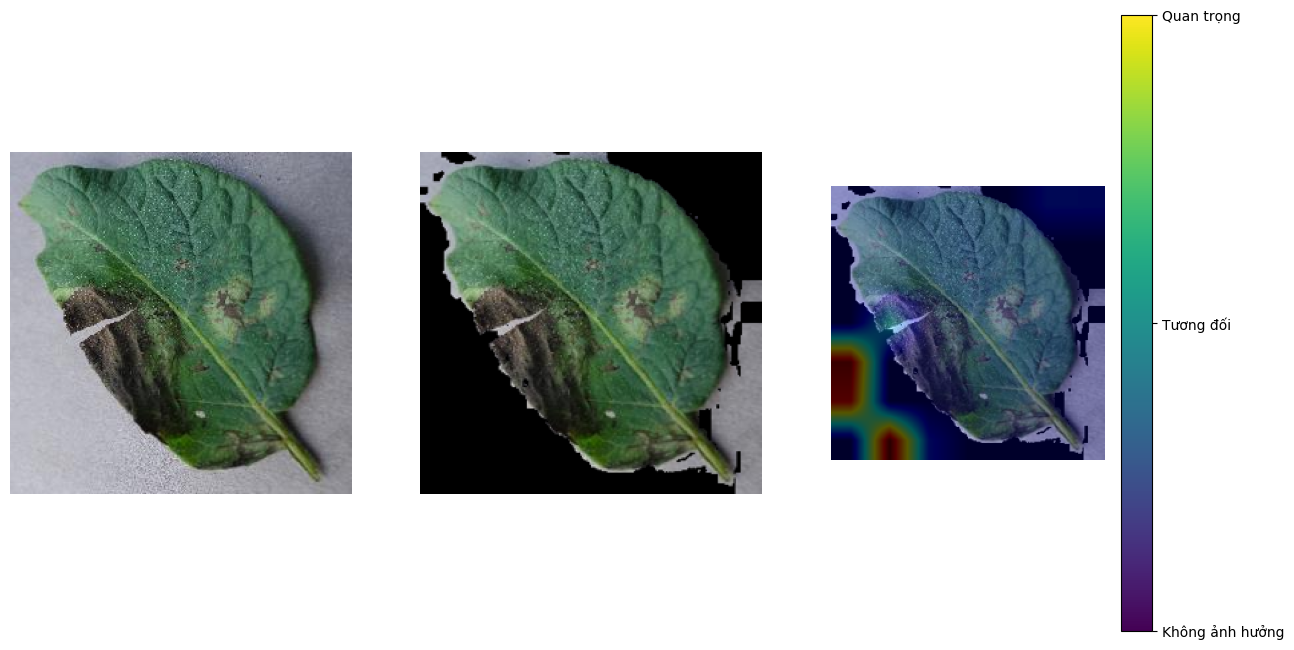

Nhãn thực: late_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


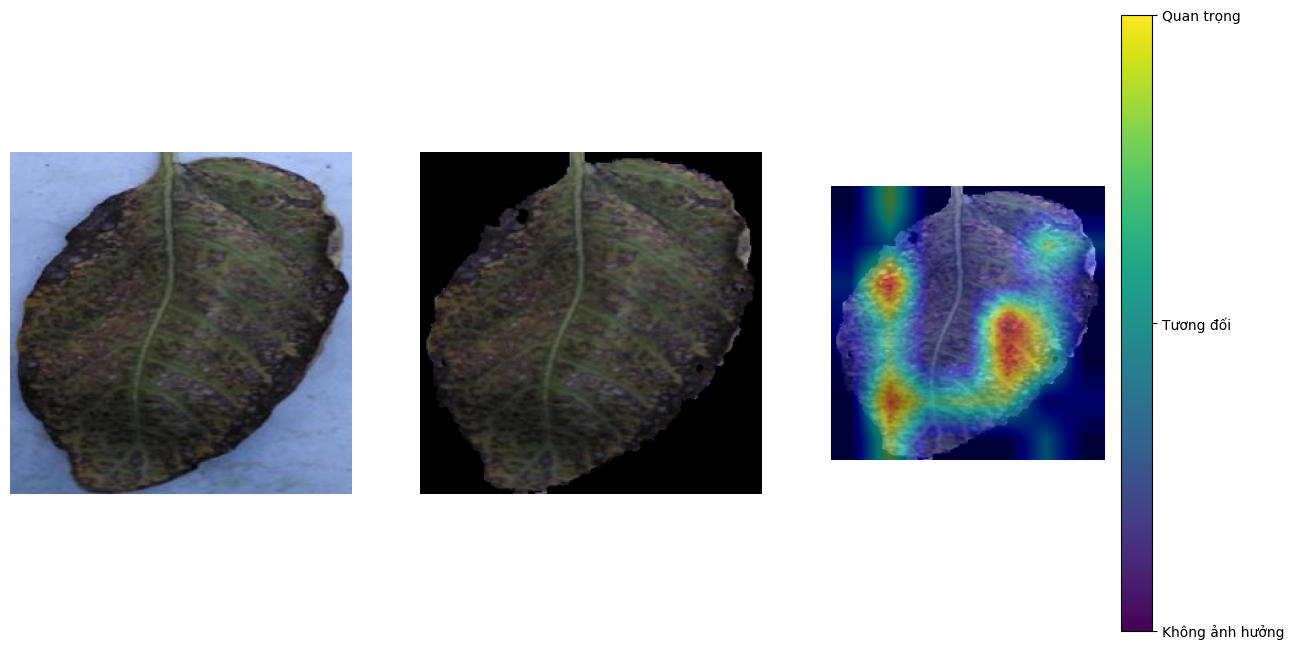

Nhãn thực: early_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


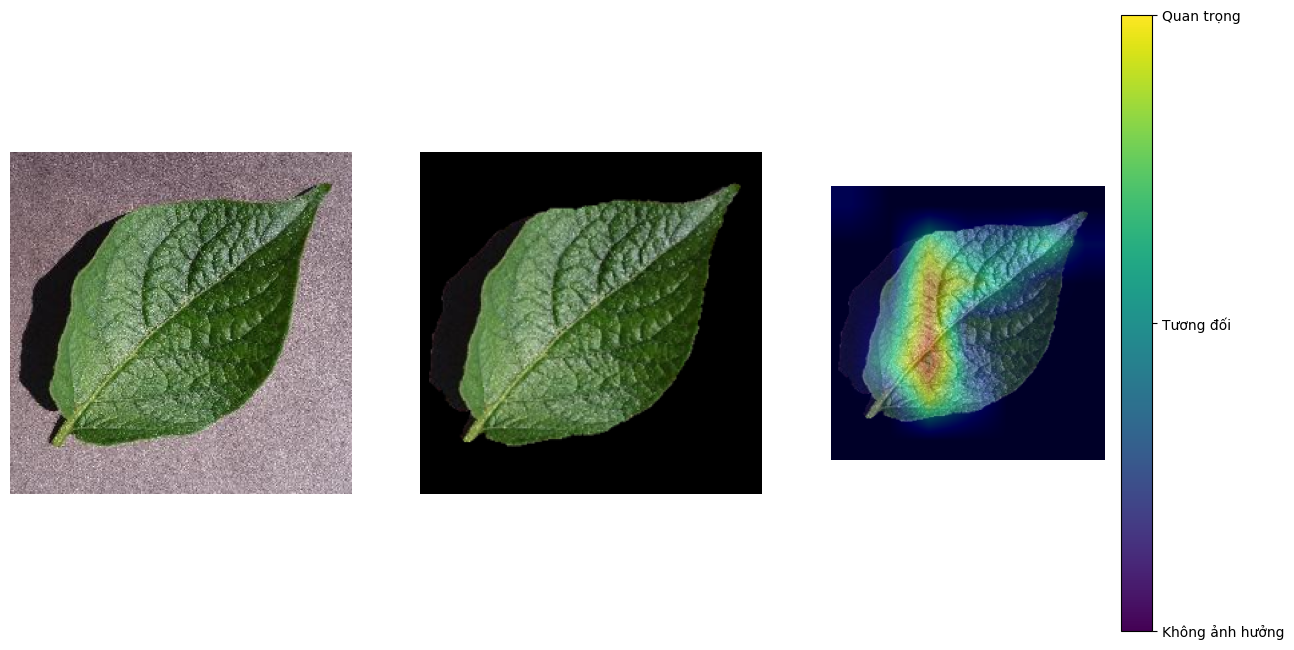

Nhãn thực: heathy
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


In [39]:
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    image_names = random.sample(os.listdir(folder_path), 1)
    # Lặp qua từng ảnh trong thư mục con
    for image_name in image_names:
        image_path = os.path.join(folder_path, image_name)
        rs, img, mask_rs=fz_fn_segment_fc(image_path,0,2,True)
        # img = Image.open(image_path)
        img_resized = rs.resize((224, 224))
        input_tensor = preprocess(rs).unsqueeze(0)
        input_tensor = input_tensor.to(device)

        # Dự đoán lớp
        output = model(input_tensor)
        class_index = torch.argmax(output).item()

        gradcam = GradCAM(model, target_layer)

        # Compute Grad-CAM
        cam = gradcam(input_tensor)

        # Visualize results
        display_gradcam(img_resized, img, cam, alpha=0.4)

        # Clean up
        gradcam.remove_hooks()


        detailed_explanation = get_detailed_explanation(class_index)
        
        print(f"Nhãn thực: {folder_name}")
        print(f"Dự đoán: {class_names[class_index]}")
        print("Dấu hiệu:")
        print(detailed_explanation.get("symptoms", "No explanation available."))

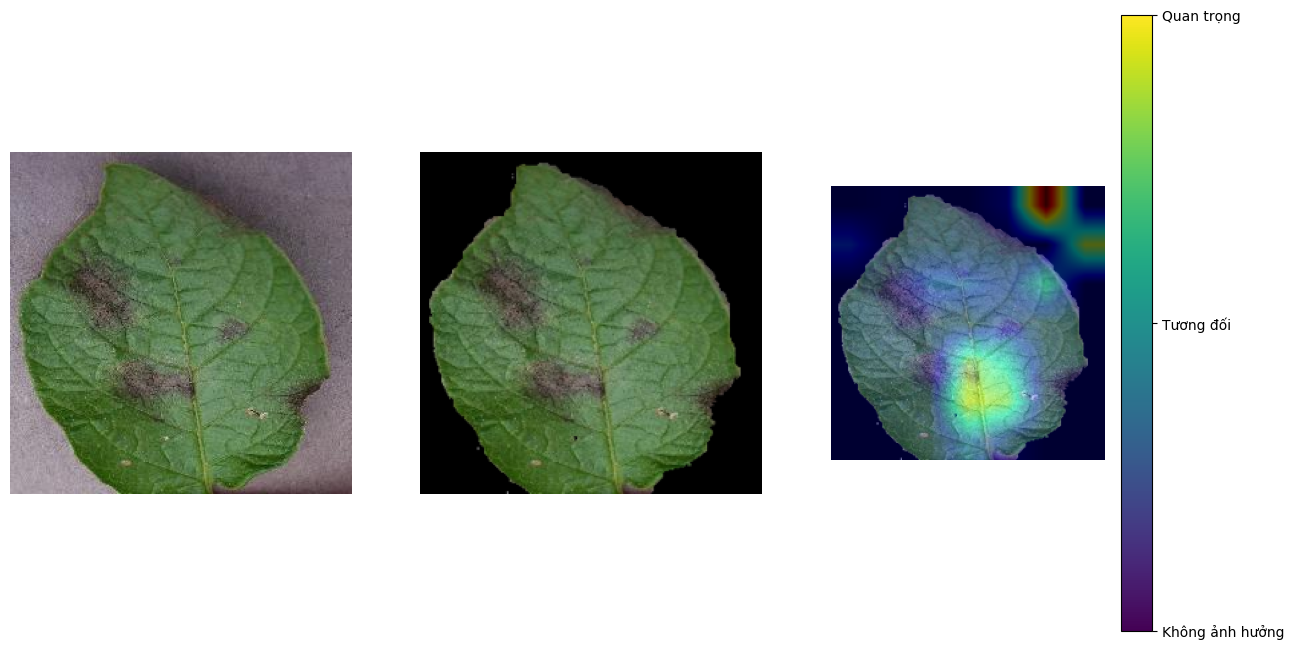

Nhãn thực: late_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


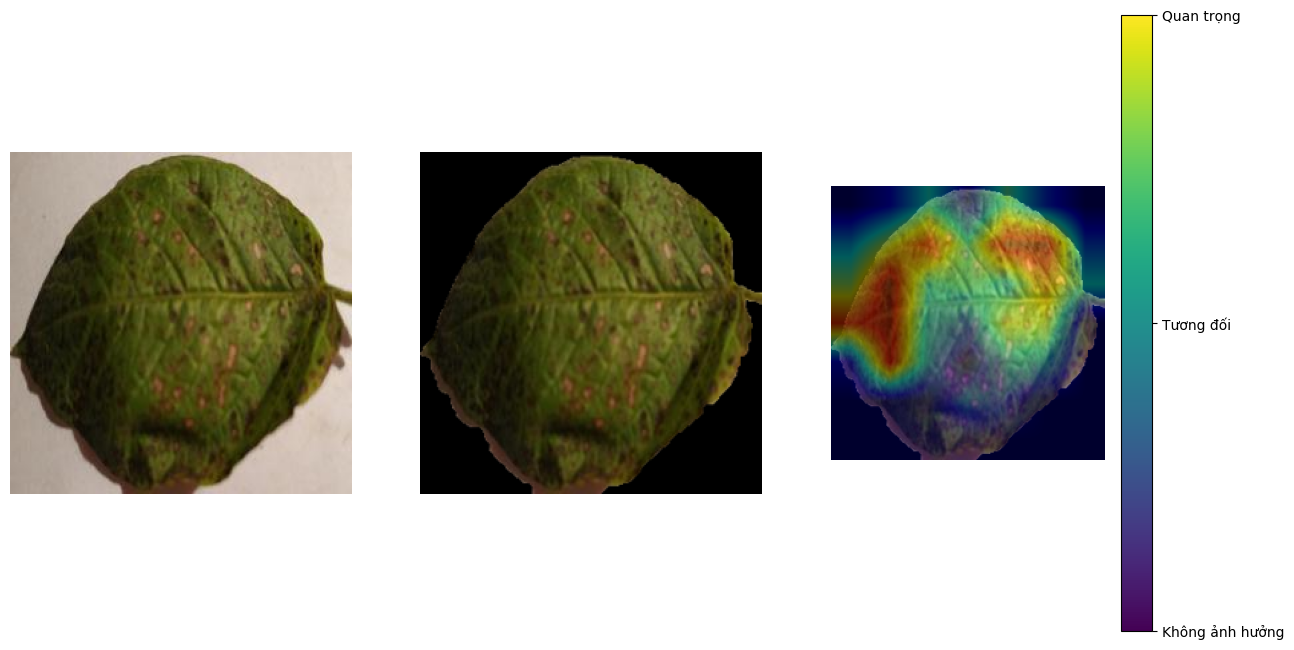

Nhãn thực: early_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


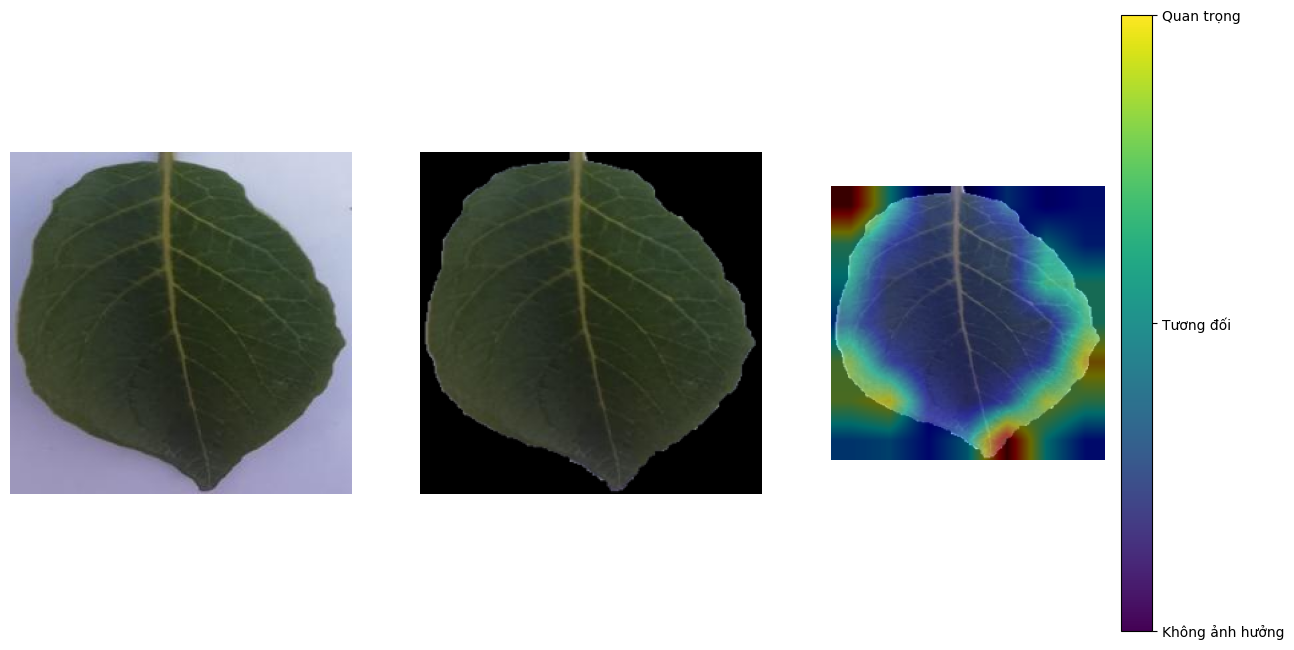

Nhãn thực: heathy
Dự đoán: healthy
Dấu hiệu:
Healthy: Không có vết bệnh hay đóm bệnh nào.


In [40]:
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    image_names = random.sample(os.listdir(folder_path), 1)
    # Lặp qua từng ảnh trong thư mục con
    for image_name in image_names:
        image_path = os.path.join(folder_path, image_name)
        rs, img, mask_rs=fz_fn_segment_fc(image_path,0,2,True)
        # img = Image.open(image_path)
        img_resized = rs.resize((224, 224))
        input_tensor = preprocess(rs).unsqueeze(0)
        input_tensor = input_tensor.to(device)

        # Dự đoán lớp
        output = model1(input_tensor)
        class_index = torch.argmax(output).item()

        gradcam = GradCAM(model1, target_layer1)

        # Compute Grad-CAM
        cam = gradcam(input_tensor)

        # Visualize results
        display_gradcam(img_resized, img, cam, alpha=0.4)

        # Clean up
        gradcam.remove_hooks()


        detailed_explanation = get_detailed_explanation(class_index)
        
        print(f"Nhãn thực: {folder_name}")
        print(f"Dự đoán: {class_names[class_index]}")
        print("Dấu hiệu:")
        print(detailed_explanation.get("symptoms", "No explanation available."))

  0%|          | 0/2000 [00:00<?, ?it/s]

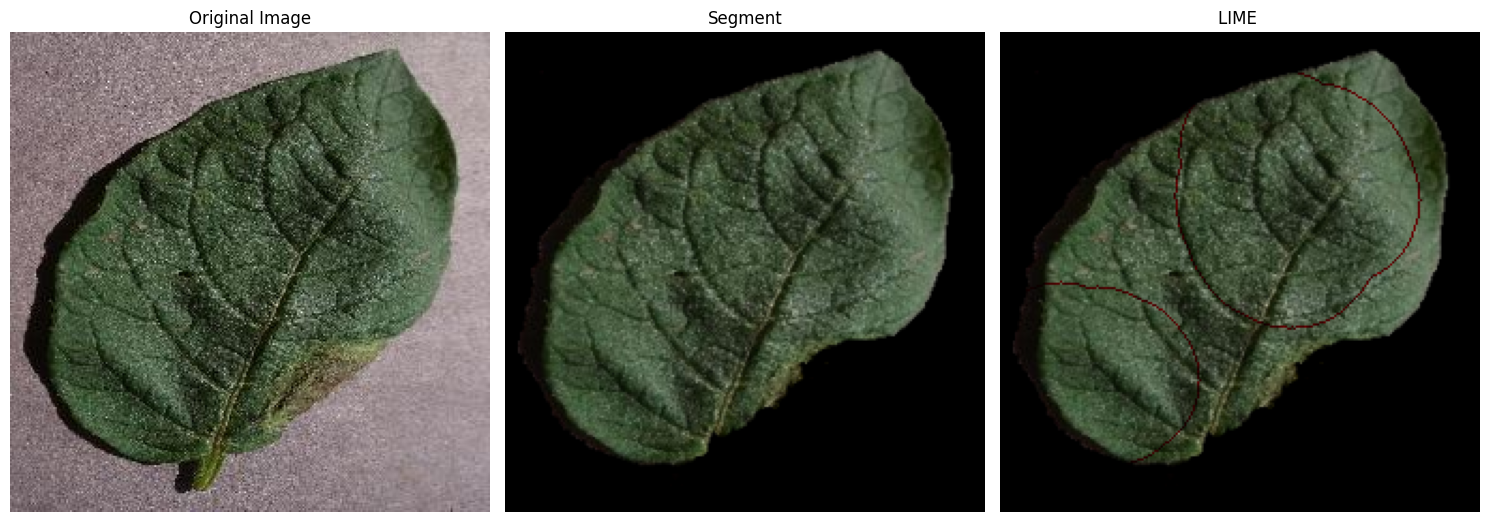

Nhãn thực: late_blight
Dự đoán: healthy
Dấu hiệu:
Healthy: Không có vết bệnh hay đóm bệnh nào.


  0%|          | 0/2000 [00:00<?, ?it/s]

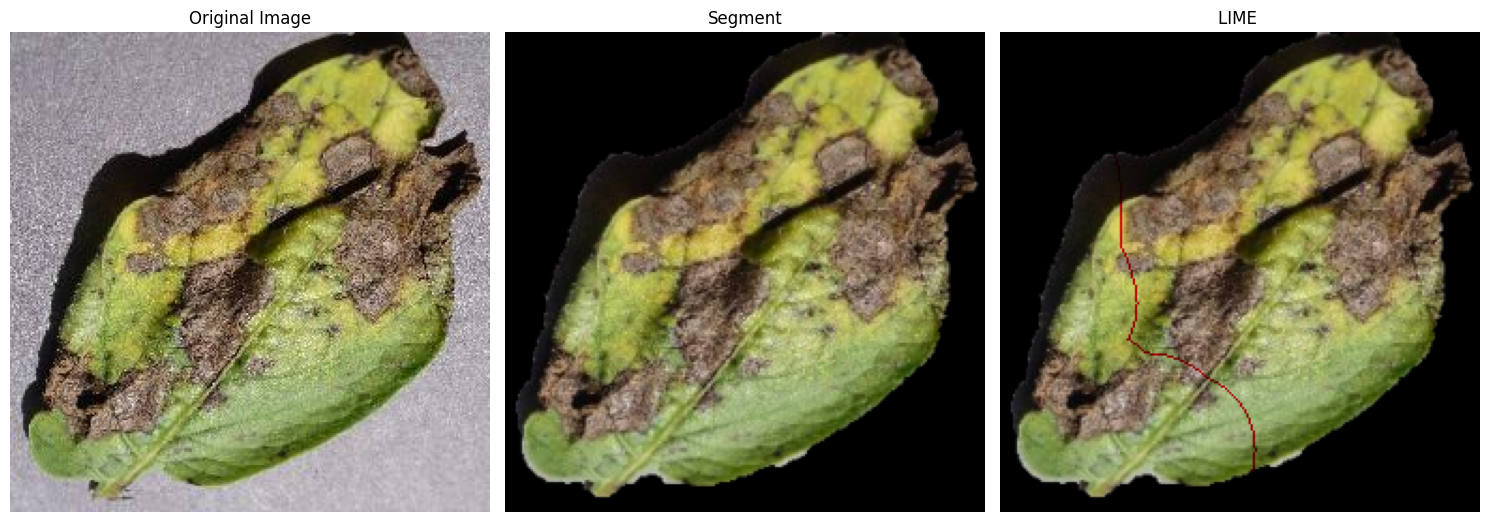

Nhãn thực: early_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


  0%|          | 0/2000 [00:00<?, ?it/s]

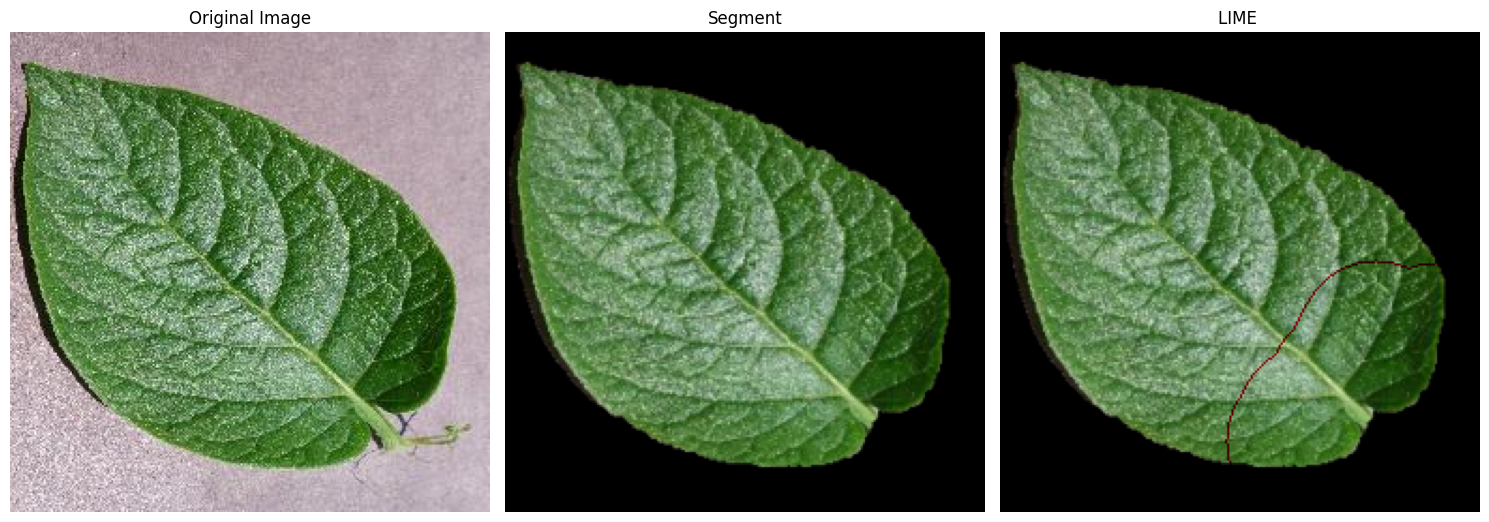

Nhãn thực: heathy
Dự đoán: healthy
Dấu hiệu:
Healthy: Không có vết bệnh hay đóm bệnh nào.


In [41]:
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    image_names = random.sample(os.listdir(folder_path), 1)
    # Lặp qua từng ảnh trong thư mục con
    for image_name in image_names:
        image_path = os.path.join(folder_path, image_name)
        rs, img, mask_rs=fz_fn_segment_fc(image_path,0,2,True)
        # img = Image.open(image_path)
        img_resized = pill_transf(rs)
        np.random.seed(3)
        temp, mask, explanation = explainer.explain(img_resized,2000, 2)
        pred_label = explanation.top_labels[0]
        # Get detailed explanation
        detailed_explanation = get_detailed_explanation(pred_label)
        explainer.visualize(img_resized, img, mask)
        print(f"Nhãn thực: {folder_name}")
        print(f"Dự đoán: {class_names[pred_label]}")
        print("Dấu hiệu:")
        print(detailed_explanation.get("symptoms", "No explanation available."))

  0%|          | 0/2000 [00:00<?, ?it/s]

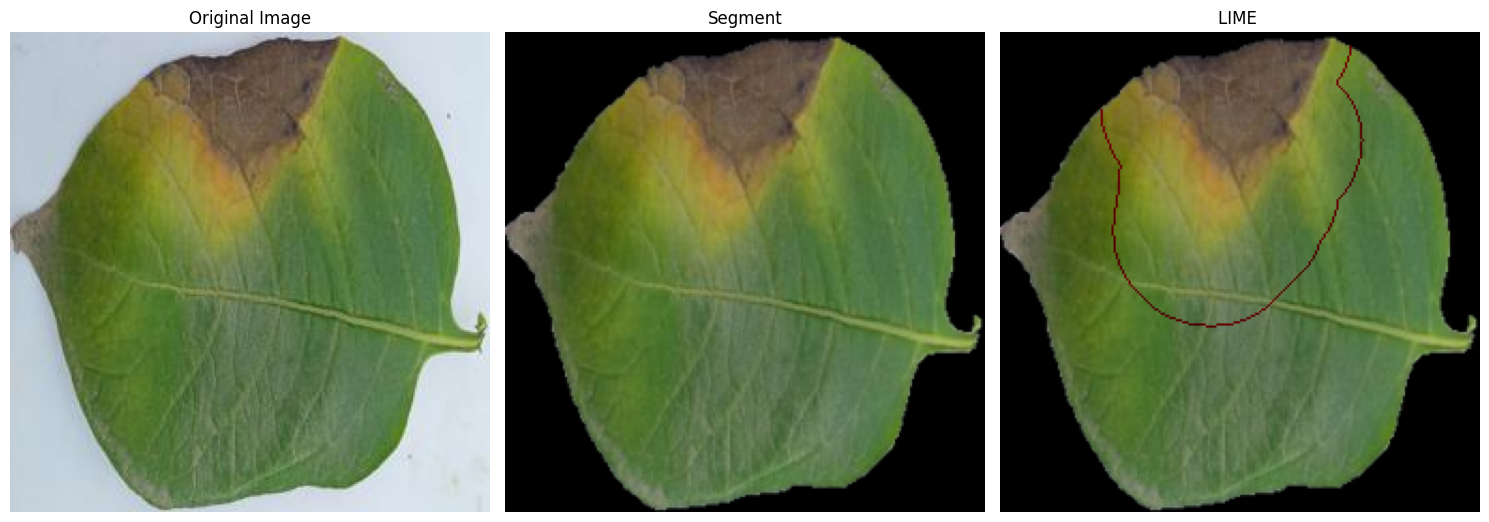

Nhãn thực: late_blight
Dự đoán: late_blight
Dấu hiệu:
Late blight: Có màu từ nhạt đến xanh đậm, vết nhỏ thường có dạng tròn và khi lan ra không có dạng cố định và cũng chuyển sang nâu đen rồi đen tím.


  0%|          | 0/2000 [00:00<?, ?it/s]

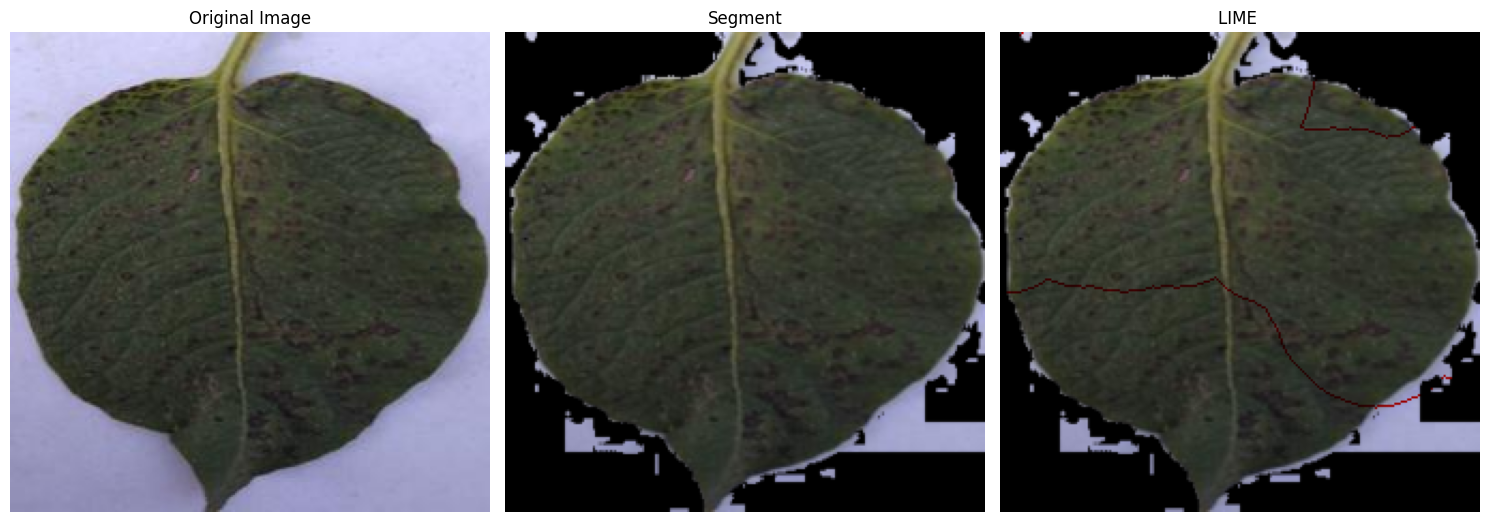

Nhãn thực: early_blight
Dự đoán: early_blight
Dấu hiệu:
Early blight (Alternaria): Vết bệnh thường nhỏ, có màu tối từ nâu sang đen. Khi vết bệnh to thì hình dạng tròn hoặc gần tròn


  0%|          | 0/2000 [00:00<?, ?it/s]

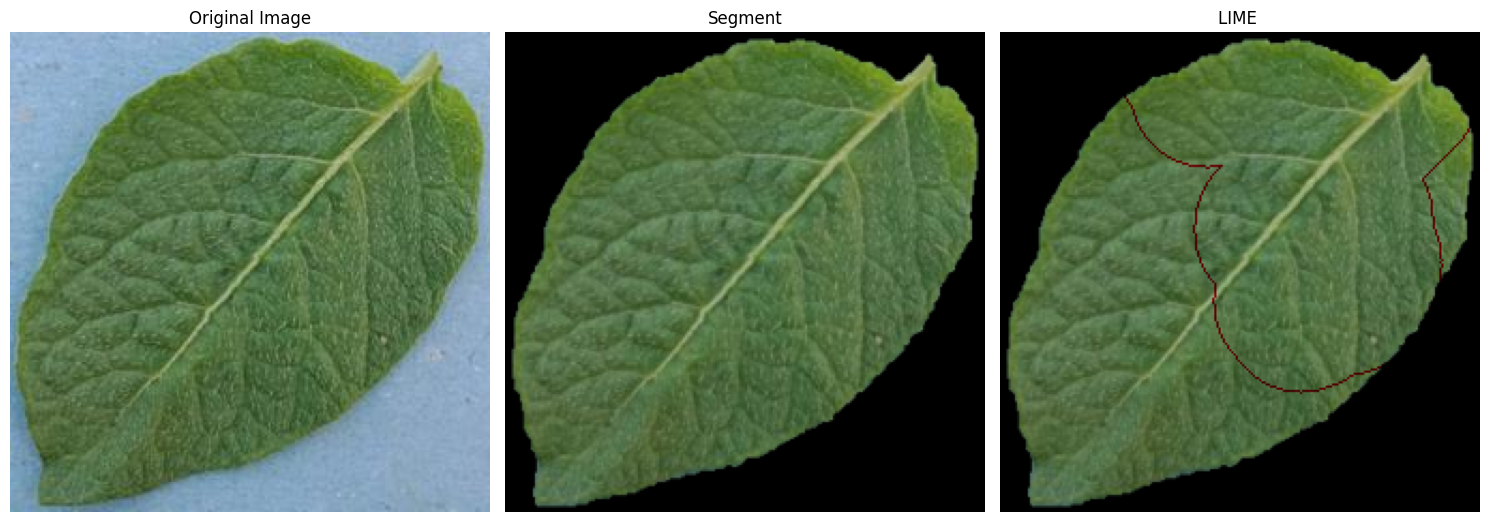

Nhãn thực: heathy
Dự đoán: healthy
Dấu hiệu:
Healthy: Không có vết bệnh hay đóm bệnh nào.


In [42]:
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    
    if not os.path.isdir(folder_path):
        continue
    image_names = random.sample(os.listdir(folder_path), 1)
    # Lặp qua từng ảnh trong thư mục con
    for image_name in image_names:
        image_path = os.path.join(folder_path, image_name)
        rs, img, mask_rs=fz_fn_segment_fc(image_path,0,2,True)
        # img = Image.open(image_path)
        img_resized = pill_transf(rs)
        np.random.seed(3)
        temp, mask, explanation = explainer1.explain(img_resized,2000, 2)
        pred_label = explanation.top_labels[0]
        # Get detailed explanation
        detailed_explanation = get_detailed_explanation(pred_label)
        explainer1.visualize(img_resized, img, mask)
        print(f"Nhãn thực: {folder_name}")
        print(f"Dự đoán: {class_names[pred_label]}")
        print("Dấu hiệu:")
        print(detailed_explanation.get("symptoms", "No explanation available."))